# Partial Least Squares

Similar to *principal component regression* (PCR), *partial least squares* (PLS) also constructs a set of linear combinations of the inputs for regression. The major difference is PLS uses $\mathbf{y}$ for this construction.

PLS is also not scaled invariant, so we need to standardize the input to have 0 mean and unit variance.

The PLS algorithm is described as follows:

   * Standardize each $\mathbf{x}_j$ to have 0 mean and unit variance. 
   * Set the initial conditions: $\hat{\mathbf{y}}^{(0)} = \bar y \mathbf{1}$, and $\mathbf{x}_j^{(0)} = \mathbf{x}_j, j = 1, \cdots, p$
   * For $m=1,2,\cdots,p$
   
      * Compute:
      $$\mathbf{z}_m = \sum_{j=1}^p\hat\varphi_{mj}\mathbf{x}_j^{(m-1)}$$
      where 
      $$\hat\varphi_{mj} = \langle\mathbf{x}_j^{(m-1)}, \mathbf{y}\rangle$$
      
      * Compute:
      $$\hat\theta_m = \frac{\langle\mathbf{z}_m,\mathbf{y}\rangle}{\langle\mathbf{z}_m, \mathbf{z}_m\rangle}$$
      
      * Update prediction:
      $$\hat{\mathbf{y}}^{(m)} = \hat{\mathbf{y}}^{(m - 1)} + \hat\theta_m \mathbf{z}_m$$
      
      * Orthogonalize $\mathbf{x}_j^{(m-1)}$:
      $$\mathbf{x}_j^{(m)} = \mathbf{x}_j^{(m-1)} - \left(\frac{\langle \mathbf{z}_m, \mathbf{x}_j^{(m-1)}\rangle}{\langle\mathbf{z}_m, \mathbf{z}_m\rangle}\right)\mathbf{z}_m$$
      for $j=1,2,\cdots, p$
      
      * To obtain $\hat\beta_{pls}(m)$, we can do it as follows:
      $$\hat\beta_{pls}(m) = (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\hat{\mathbf{y}}^{(m)}$$

### Python Implementation

We use *Prostate Cancer* data to test our implementation of the PLS algorithm. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ml_datasets.esl import ProstateCancer
from sklearn import preprocessing
from esl.chapter03 import kfold

In [2]:
prostate_cancer = ProstateCancer(verbose=0)

In [3]:
df = prostate_cancer.load()

train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(df_x[train_test=='T'].values)
x_test = scaler.transform(df_x[train_test=='F'].values)

y_train_temp = df_y[train_test=='T'].copy().values
y_train = y_train_temp - np.mean(y_train_temp)

y_test_temp = df_y[train_test=='F'].copy().values
y_test = y_test_temp  - np.mean(y_train_temp)

Next, we build the `PartialLeastSquares` class based on the mentioned PLS algorithm.

This class contains two methods:

   * `fit`: to fit the model using the PLS algorithm. Here, we'll obtain the coefficients $\hat\beta_{ls}$.
   * `predict`: to generate prediction given the computed $\hat\beta_{pls}$.
   * `error`: to obtain the squared and mean-squared errors.

The following is the `PartialLeastSquares` class:

In [4]:
class PartialLeastSquares:
    def __init__(self, **kwargs):
        self.num_direction = kwargs.get('num_direction', 1)
        
    def fit(self, x, y):
        x_prev = x.copy()
        y_hat_prev = (np.ones_like(y) * np.mean(y))
        z = np.zeros_like(x)
        phi = np.zeros((x.shape[1], x.shape[1]))
        theta = np.zeros(x.shape[1])
        for m in range(1, self.num_direction + 1):
            for j in range(x.shape[1]):
                phi[m - 1, j] = x_prev[:, j].T @ y
                z[:, m - 1] += phi[m - 1, j] * x_prev[:, j]
            
            theta[m - 1] = (z[:, m - 1].T @ y) / (z[:, m - 1].T @ z[:, m - 1])

            y_hat_prev = y_hat_prev + theta[m - 1] * z[:, m - 1]

            for j in range(x.shape[1]):
                x_prev[:, j] = x_prev[:, j] -  ((z[:, m - 1].T @ x_prev[:, j]) / (z[:, m - 1].T @ z[:, m - 1])) * z[:, m - 1]

        self.beta_hat = np.linalg.inv(x.T @ x) @ x.T @ y_hat_prev
   
    def predict(self, x):
        return x @ self.beta_hat
    
    def error(self, x, y):
        y_hat = self.predict(x)
        error = y_hat - y
        
        return error.T @ error, (error.T @ error) / len(error)

#### Cross-Validation to find the best number of components/directions

In the book, to find the best number of directions, we need to perform cross validation on the training data. The following is the main loop to perform cross validation. For every number of components, we perform training on the 10 folds and record the MSE:

In [5]:
x_dict, y_dict = kfold(x_train, y_train, nfold=10, seed=5)
num_directions = np.arange(x_train.shape[1] + 1)
RSS = dict()
MRSS = dict()

for m in num_directions:
    RSS_temp = []
    MRSS_temp = []
    
    for fold in x_dict.keys():
        if m == 0:
            y_train_temp = y_dict[fold]['train'].copy()
            y_val_temp = y_dict[fold]['val'].copy()
            error = (y_val_temp).T @ (y_val_temp)
            merror = error / len(y_val_temp)
            
        else:
            x_train_temp = x_dict[fold]['train'].copy()
            x_val_temp = x_dict[fold]['val'].copy()

            y_train_temp = y_dict[fold]['train'].copy()
            y_val_temp = y_dict[fold]['val'].copy()
            
            pls = PartialLeastSquares(num_direction=m)
            pls.fit(x_train_temp, y_train_temp)
            error, merror = pls.error(x_val_temp, y_val_temp)

        RSS_temp.append(error)
        MRSS_temp.append(merror)
        
    RSS[m] = RSS_temp
    MRSS[m] = MRSS_temp

**Note**: The cross-validation algorithm requires randomly generating data indices; therefore, the performance of the training depends on the randomly partitioned data.

We use the *one-standard error* rule to choose the most parsimonious model whose error is no more than one standard error above the error of the best model. The code below does this:

In [6]:
x_cv = np.array(list(RSS.keys()))

# calculate the mean of MSE from the 10-fold cross validation
y_cv_mean = np.array([np.mean(MRSS[key]) for key in MRSS.keys()])

# calculate the standard error
y_cv_std = np.array([np.std(MRSS[key]) / (10 ** 0.5) for key in MRSS.keys()])

# find the most parsimonious model
upper_bound = np.min(y_cv_mean) + y_cv_std[np.argmin(y_cv_mean)]
best_dir = np.min(np.where(y_cv_mean <= upper_bound)[0])

Now, we plot the cross validation error on every number of components (Figure 3.7 - Bottom-Left):

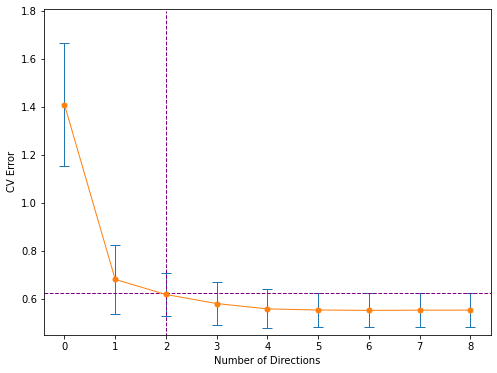

In [7]:
plt.figure(figsize=(8, 6))
plt.errorbar(x_cv, y_cv_mean, yerr=y_cv_std, capsize=5, ecolor='C0', color='C1', elinewidth=1, linewidth=1, marker='o', markersize=5)
x_cvv = np.linspace(-0.4, 8.4, 20)
y_cvv = np.linspace(0.4, 1.8, 20)

# this is to plot the purple horizontal line
plt.plot(x_cvv, upper_bound * np.ones(len(x_cvv)), '--', color='purple', linewidth=1)

# this is to plot the purple vertical line
plt.plot(best_dir * np.ones(len(y_cvv)), y_cvv, '--', color='purple', linewidth=1)

plt.xlim([-0.4, 8.4])
plt.ylim([0.45, 1.81])
plt.xlabel('Number of Directions')
plt.ylabel('CV Error')
plt.show()

The following part generates the PLS column of Table 3.3.

Since we know that from the cross-validation the best result is obtained when the number of directions equals to 2, we retrain the model using this number of directions. Subsequently, we generate the mean-squared and standard errors of the test data:

In [8]:
pls = PartialLeastSquares(num_direction=2)
pls.fit(x_train, y_train)

In [9]:
# calculate the mse and std. error
y_hat = x_test @ pls.beta_hat
error = (y_test - y_hat).T @ (y_test - y_hat)
mse = error / len(y_test)
std_error = np.sqrt(np.var((y_test - y_hat) ** 2) / (len(y_test) - 1))

beta_0 = np.mean(df_y[train_test=='T'].copy().values)
pls_dframe = pd.DataFrame({'PLS': np.append(np.append(beta_0, pls.beta_hat), np.array([mse, std_error]))})
pls_dframe['Term'] = ['Intercept'] + list(prostate_cancer.meta[:-1]) + ['Test Error', 'Std Error']
cols = pls_dframe.columns[::-1]
pls_dframe = pls_dframe[cols].replace(0, '')
pls_dframe.style.\
    hide_index().\
    set_caption('Estimated Coefficients').\
    set_precision(3).\
    apply(lambda x: ['font-weight: bold' if x['Term'] in ['Test Error', 'Std Error'] else '' for i in x], axis=1)

Term,PLS
Intercept,2.452
lcavol,0.433
lweight,0.358
age,-0.021
lbph,0.241
svi,0.257
lcp,0.085
gleason,0.006
pgg45,0.084
Test Error,0.536
